#### Проект. Рекомендательные системы в банковской сфере. Моделирование

Содержание  
 - Начало: импорт библиотек, настройка параметров, определения функций
 - Запуск MLFlow
 - Обучение модели
 - Подготовка функций для встраивания модели в сервис предсказаний
 - Получение и интерпретация метрик
 - Сравнение метрик модели с константными предсказаниями
 - Получение рекомендаций на основе вероятностей предсказаний
 - Итоги этапа моделирования

##### Начало: импорт библиотек, настройка параметров, определения функций

In [1]:
# Import essential libraries for data manipulation and I/O operations
import pandas as pd
import numpy as np
import os
import json
import joblib
import warnings
import matplotlib.pyplot as plt
import requests
from typing import Optional, List, Dict
#import subprocess
from dotenv import load_dotenv
#import psutil
from datetime import datetime

# Import CatBoost for machine learning tasks
#from catboost import CatBoostClassifier

# Import metrics from sklearn for evaluating model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

# Import preprocessing and pipeline tools from sklearn
#from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
#from sklearn.compose import ColumnTransformer
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.multioutput import MultiOutputClassifier
#from sklearn.pipeline import Pipeline

# MLflow for model tracking
import mlflow

# Custom utility imports for data processing
from utils.config import (
    new_columns, attrs, RANDOM_STATE,
    DATA_DIR, MODEL_DIR, TRAIN_PARQUET, TEST_PARQUET,
    START_TRAIN_DATE,
    MODEL_PKL, FITTED_MODEL, MODEL_PARAMS,
    TRACKING_SERVER_CONN, path,
    date_columns, LUCKY_USER, SAMPLE_JSON
)
from utils.preprocess import process_na

from utils.preprocess import DataFrameProcessor, frequency_encoding, process_na

# Load environment variables from .env file
load_dotenv()

# Set global options for precision in numpy and pandas formatting
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

# Optionally, suppress runtime warnings (uncomment if needed)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def calculate_roc_auc(y_true: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    """
    Calculate ROC AUC scores (micro, macro, and average) for multi-output classification.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.

    Returns:
    dict: ROC AUC scores.
    """
    if isinstance(y_pred_proba, list):
        y_pred_proba = np.array(y_pred_proba)

    if len(y_pred_proba.shape) == 3:
        y_pred_proba_class_1 = y_pred_proba[:, :, 1].T
    else:
        y_pred_proba_class_1 = y_pred_proba

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values

    # Filter columns with more than one unique value
    valid_columns = [col for col in range(y_true.shape[1]) if len(np.unique(y_true[:, col])) > 1]

    return {
        'micro': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='micro'),
        'macro': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='macro'),
        'average': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='weighted')
    }


def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray, zero_division: int = 0) -> pd.DataFrame:
    """
    Calculate various classification metrics such as Accuracy, Precision, Recall, F1, and ROC AUC.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred (np.ndarray): Predicted labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    zero_division (int): Determines the behavior when division by zero occurs (default is 0).

    Returns:
    pd.DataFrame: DataFrame with calculated metrics for micro, macro, and average scores.
    """
    metrics = {
        'Accuracy': {
            'micro': -1,
            'macro': -1,
            'average': accuracy_score(y_true, y_pred)
        },
        'Precision': {
            'micro': precision_score(y_true, y_pred, average='micro', zero_division=zero_division),
            'macro': precision_score(y_true, y_pred, average='macro', zero_division=zero_division),
            'average': precision_score(y_true, y_pred, average='weighted', zero_division=zero_division)
        },
        'Recall': {
            'micro': recall_score(y_true, y_pred, average='micro', zero_division=zero_division),
            'macro': recall_score(y_true, y_pred, average='macro', zero_division=zero_division),
            'average': recall_score(y_true, y_pred, average='weighted', zero_division=zero_division)
        },
        'F1': {
            'micro': f1_score(y_true, y_pred, average='micro', zero_division=zero_division),
            'macro': f1_score(y_true, y_pred, average='macro', zero_division=zero_division),
            'average': f1_score(y_true, y_pred, average='weighted', zero_division=zero_division)
        },
        'ROC AUC': calculate_roc_auc(y_true, y_pred_proba)
    }

    return pd.DataFrame(metrics).T


def plot_roc_curve(y_true: np.ndarray, y_pred_proba: np.ndarray, label_name: str) -> None:
    """
    Plot the ROC curve for binary classification.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    label_name (str): Label for the ROC curve.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.4f})')

##### Запуск эксперимента в MLFlow

In [3]:
EXPERIMENT_NAME = 'Спринт 6: Проект'
RUN_NAME = "CBC"
REGISTRY_MODEL_NAME = 'model_sprint_6_2'

In [4]:
# Сервер MLFlow должен быть запущен (см. Instructions.md):
#  - скриптом sh run_mlflow.sh, или
#  - в составе общего контейнера docker compose up --build

def check_mlflow_server(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print("MLFlow сервер запущен.")
            return True
        else:
            print("MLFlow сервер вернул статус:", response.status_code)
            return False
    except requests.exceptions.ConnectionError:
        raise Exception("Не удалось связаться с MLFlow server.") 


if check_mlflow_server(TRACKING_SERVER_CONN):
    mlflow.set_tracking_uri(TRACKING_SERVER_CONN)
    mlflow.set_registry_uri(TRACKING_SERVER_CONN)

MLFlow сервер запущен.


In [5]:
# Query all runs from the experiment (use experiment_id or experiment_name)
runs = mlflow.search_runs(experiment_names=[ 'Спринт 6: Проект'])

# Filter for active (RUNNING) runs
active_runs = runs[runs['status'] == 'RUNNING']

if not active_runs.empty:
    print(f"Найдено активных запусков: {len(active_runs)}:")
    for idx, row in active_runs.iterrows():
        print(f"- Run ID: {row['run_id']}, запущен: {row['start_time']}")
else:
    print("Активных запусков нет.")

Найдено активных запусков: 1:
- Run ID: 73e31b7536e749eb852df2f5146dd43d, запущен: 2024-09-23 15:02:29.235000+00:00


In [6]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

run = mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id)
print(f"Запуск нового эксперимента с ID: {run.info.run_id}")


Запуск нового эксперимента с ID: 34f5ed19e6554389a7bc21b5615db23e


##### Обучение модели

Параметры модели, которую мы построили на предыдущем этапе:  
CatBoostClassifier(iterations=100, verbose=0, class_weights = [1, 4])

Среди задач проекта нет глубокой оптимизации модели.  
Поэтому получим результат с некоторыми упрощениями:  
 - оставим небольшок количество итераций (100). Исходя из структуры данных, увеличение количества итераций до 500-1000 улучшит результат, но обучение на двух десятках таргетов займет много времени
 - нужно обязательно "утяжелить" миноритарный класс, подбор соотношения - задача дальнейшей оптимизации модели
 - остальные параметры оставим по умолчанию, хотя может быть необходимость настроить параметры деревьев, learning rate и т.д.
 - также усечем тренировочные данные с 14 до 8 месяцев. Так мы сократим время обучения, а также сконцентрируемся на более "свежих" данных.


Параметры модели, которую мы построили на предыдущем этапе:  
CatBoostClassifier(iterations=100, verbose=0, class_weights = [1, 4])

Среди задач проекта нет глубокой оптимизации модели.  
Поэтому получим результат с некоторыми упрощениями:  
 - оставим небольшок количество итераций (100). Исходя из структуры данных, увеличение количества итераций до 500-1000 улучшит результат, но обучение на двух десятках таргетов займет много времени
 - нужно обязательно "утяжелить" миноритарный класс, подбор соотношения - задача дальнейшей оптимизации модели
 - остальные параметры оставим по умолчанию, хотя может быть необходимость настроить параметры деревьев, learning rate и т.д.
 - также усечем тренировочные данные с 14 до 8 месяцев. Так мы сократим время обучения, а также сконцентрируемся на более "свежих" данных.


In [7]:
%%time
# ~ 16 min

df_train = pd.read_parquet(path(DATA_DIR, TRAIN_PARQUET))

df_train = process_na(df_train)
df_train = df_train[df_train.fetch_date >= START_TRAIN_DATE]

df_test = pd.read_parquet(path(DATA_DIR, TEST_PARQUET))
df_test = process_na(df_test)

targets = df_train.attrs['target__']
        
X_train, y_train = df_train.drop(columns=targets), df_train[targets]
X_test, y_test = df_test.drop(columns=targets), df_test[targets]

target_cols = [col for col in y_train.columns if y_train[col].nunique() > 1]

#model = joblib.load(MODEL_DIR + MODEL_PKL)
#model.fit(X_train, y_train[target_cols])

model = joblib.load(path(MODEL_DIR, FITTED_MODEL))

CPU times: user 6.88 s, sys: 2.96 s, total: 9.84 s
Wall time: 6.53 s


Можно вывести важности признаков, но эти данные потребуют дополнительного анализа по всем таргетам.

In [8]:
df_importance = pd.DataFrame([model.steps[2][1].estimators_[0].get_feature_importance()], columns=X_train.columns).T.sort_values(by=0, ascending=False)
df_importance[df_importance[0] > 1]

,0
ind_1m_debit_account,29.3706
id,22.0571
gender,15.8331
ind_employee,9.4745
province_name,8.7455
ind_1m_mature_acc_3,4.3840
age,3.6221
ind_1m_tax_account,2.5134
entry_channel,1.4744


(Для первого таргета пол находится на 3-м месте, хотя общей зависимости таргетов от этой переменной не было.)
  
Получим данные для метрик.

In [9]:
%%time
# ~ 3 min

joblib.dump(model, path(MODEL_DIR, FITTED_MODEL))

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_true = y_test[target_cols]

CPU times: user 3min 20s, sys: 618 ms, total: 3min 21s
Wall time: 3min 10s


##### Подготовка функций для встраивания модели в сервис предсказаний

Для мониторинга предсказаний нам потребуются имена таргетов на русском (для FastAPI) и на английском (Graphite принимает только ASCII названия).  
Для обработки часто встречающихся пропусков в 'income' сохраним среднее значение как параметр.

In [14]:
X_train.attrs

{'fetch_date': {'rus': 'Колонка для разделения таблицы',
  'eng': '',
  'esp': 'fecha_dato',
  'values': {}},
 'id': {'rus': 'Идентификатор пользователя',
  'eng': '',
  'esp': 'ncodpers',
  'values': {}},
 'ind_employee': {'rus': 'Статус занятости',
  'eng': '',
  'esp': 'ind_empleado',
  'values': {'A': 'трудоустроен',
   'B': 'безработный, раньше работал',
   'F': 'иждивенец',
   'N': 'безработный',
   'P': 'пассивный (статус не определён)'}},
 'country_of_residence': {'rus': 'Страна резидентства',
  'eng': '',
  'esp': 'pais_residencia',
  'values': {}},
 'gender': {'rus': 'Пол', 'eng': '', 'esp': 'sexo', 'values': {}},
 'age': {'rus': 'Возраст', 'eng': '', 'esp': 'age', 'values': {}},
 'registration_date': {'rus': 'Дата, когда клиент впервые заключил договор в банке',
  'eng': '',
  'esp': 'fecha_alta',
  'values': {}},
 'ind_new_client': {'rus': 'Признак нового клиента',
  'eng': '',
  'esp': 'ind_nuevo',
  'values': {'1': 'если клиент зарегистрировался за последние 6 месяцев'}},

In [13]:
target_cols

['target__ind_1m_guarantee',
 'target__ind_1m_checking_acc',
 'target__ind_1m_derivatives',
 'target__ind_1m_payroll_acc',
 'target__ind_1m_junior_acc',
 'target__ind_1m_mature_acc_3',
 'target__ind_1m_operations_acc',
 'target__ind_1m_pension_acc_2',
 'target__ind_1m_short_term_deposit',
 'target__ind_1m_medium_term_deposit',
 'target__ind_1m_long_term_deposit',
 'target__ind_1m_digital_account',
 'target__ind_1m_cash_funds',
 'target__ind_1m_mortgage',
 'target__ind_1m_pension_plan',
 'target__ind_1m_loans',
 'target__ind_1m_tax_account',
 'target__ind_1m_credit_card',
 'target__ind_1m_securities',
 'target__ind_1m_home_acc',
 'target__ind_1m_salary_acc',
 'target__ind_1m_pension_obligation_account',
 'target__ind_1m_debit_account']

In [12]:
 [X_train.attrs[x[len('target__'):]][0] for x in target_cols]

KeyError: 0

In [10]:
target_names = [X_train.attrs[x[len('target__'):]][0] for x in target_cols]
target_names_eng = [X_train.attrs[x[len('target__'):]][1] for x in target_cols]
income_mean = X_train['income'].mean()

model_params = {
    'target_names': target_names,
    'target_names_eng': target_names_eng,
    'income_mean': income_mean
}

model_params_file = path(MODEL_DIR, MODEL_PARAMS)

with open(model_params_file, 'w') as f:
    json.dump(model_params, f)

mlflow.log_artifact(model_params_file)

KeyError: 0

Для тестирования сервиса нам нужно будет генерировать json запросы, а для получения предсказаний нужен DataFrame.
Для этого создадим некоторые функции преобразования, смысл которых понятен из аннотаций.

In [11]:
def safe_strftime(date_value: pd.Timestamp) -> Optional[str]:
    """
    Safely convert a pandas Timestamp to a string in 'dd-mm-yyyy' format.
    If the value is NaT (not a time), return None.

    Parameters:
    - date_value (pd.Timestamp): A timestamp to convert.

    Returns:
    - str or None: The formatted date string or None if the value is NaT.
    """
    if pd.isnull(date_value):  # Check for NaT (Not a Time)
        return None
    return date_value.strftime('%d-%m-%Y')  # Format the date as dd-mm-yyyy


def save_row_to_json(row: pd.Series, json_file: str) -> None:
    """
    Save a pandas Series (row) to a JSON file, converting datetime fields safely.

    Parameters:
    - row (pd.Series): The row of data to save.
    - json_file (str): The path to the JSON file to save the data.

    Returns:
    - None: The function writes the row to a file and doesn't return anything.
    """
    row = row.copy()  # Make a copy of the row to avoid modifying the original
    
    # Safely convert datetime fields to string format
    row[date_columns] = row[date_columns].apply(lambda col: safe_strftime(col))
    
    # Convert the row to JSON format
    json_data = row.to_json(orient='index', indent=4)
    
    # Write the JSON data to the specified file
    with open(json_file, 'w') as f:
        f.write(json_data)

save_row_to_json(X_test.iloc[LUCKY_USER], path(MODEL_DIR, SAMPLE_JSON))


In [12]:
def load_row_from_json(json_file: str) -> pd.DataFrame:
    """
    Load a row from a JSON file and convert it into a pandas DataFrame.
    Handles datetime fields and assigns a mean value to the 'income' column if it's missing.

    Parameters:
    - json_file (str): Path to the JSON file.

    Returns:
    - pd.DataFrame: A DataFrame containing the loaded row.
    """
    # Load the JSON data as a pandas Series
    row_loaded = pd.read_json(json_file, typ='series')
    
    # Convert string dates back into datetime format
    row_loaded[date_columns] = row_loaded[date_columns].apply(pd.to_datetime, format='%d-%m-%Y')

    # Handle missing 'income' value by assigning the mean income
    if row_loaded['income'] is None:
        row_loaded['income'] = income_mean
    
    # Return as a single-row DataFrame
    return pd.DataFrame([row_loaded])


def interpret_predictions(predictions: list, lang: str = 'rus', is_integer=True) -> Dict[str, int]:
    """
    Interpret the model predictions by mapping the prediction columns to target names.

    Parameters:
    - predictions (list): List of predicted values.
    - lang (str): Language for target names, 'rus' for Russian, 'eng' for English.

    Returns:
    - dict: A dictionary mapping target names to predicted values.
    """
    # Select appropriate target names based on language
    if lang == 'rus':
        targets = target_names
    else:
        targets = target_names_eng
    
    # Map the predictions to target names
    if is_integer:
        return {name: int(pred) for pred, name in zip(predictions, targets)}
    
    return {name: pred for pred, name in zip(predictions, targets)}


prediction = model.predict(load_row_from_json(path(MODEL_DIR, SAMPLE_JSON)))[0]

predictions_dict = interpret_predictions(prediction, lang='rus')

for target, prediction in predictions_dict.items():
    print(target, prediction)

Банковская гарантия 0
Текущие счета 1
Деривативный счёт 0
Зарплатный проект 0
Детский счёт 0
Особый счёт 3 0
Особый счёт 0
Особый счёт 2 0
Краткосрочный депозит 0
Среднесрочный депозит 0
Долгосрочный депозит 0
Цифровой счёт 0
Денежный средства 0
Ипотека 0
Пенсионный план 0
Кредит 0
Налоговый счёт 0
Кредитная карта 0
Ценные бумаги 0
Домашний счёт 0
Аккаунт для выплаты зарплаты 1
Аккаунт для пенсионных обязательств 0
Дебетовый аккаунт 0


В итоге мы создали образец json в файле sample.json и получили функцию для вывода предсказаний модели на английском и русском языках.  

Вернемся к оценке предсказаний.

##### Получение и интерпретация метрик

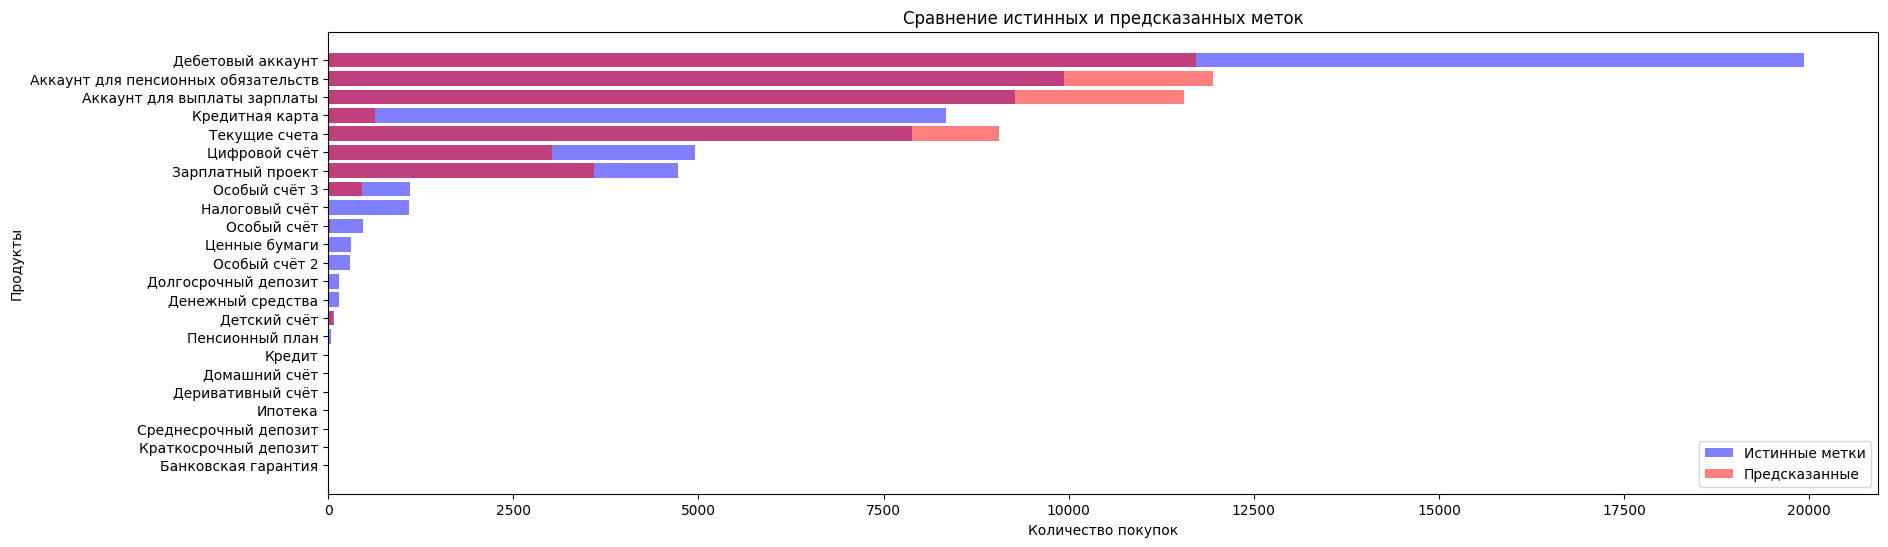

In [13]:
plot_data = pd.DataFrame({
    'True': y_true.sum(axis=0),
    'Predicted': np.sum(y_pred, axis=0)
})

plot_data_sorted = plot_data.sort_values(by='True')

plt.figure(figsize=(20, 6))
plt.title(f"Сравнение истинных и предсказанных меток")
plt.ylabel("Продукты")
plt.xlabel("Количество покупок")

y_labels = [df_train.attrs[col[8:]][0] for col in plot_data_sorted.index]
plt.barh(y_labels, plot_data_sorted['True'], label='Истинные метки', alpha=0.5, color='b')
plt.barh(y_labels, plot_data_sorted['Predicted'], label='Предсказанные', alpha=0.5, color='r')

plt.legend(loc='lower right')

plot_path = "compare_plot.png"
plt.savefig(plot_path)

plt.show()


mlflow.log_artifact(plot_path)

os.remove(plot_path)

Видим, что модель (неглубоко обученная) неплохо собирает положительные таргеты, отличает их друг от друга, но ошибается в частоте предсказаний,  неравномерно недооценивает/переоценивает различные таргеты.  
Залогируем модель, а потом и метрики.

In [14]:
warnings.filterwarnings("ignore", category=UserWarning)

X_test['ind_spouse_employee'] = X_test['ind_spouse_employee'].fillna(0)

mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path='models',
    registered_model_name=REGISTRY_MODEL_NAME,
    signature=mlflow.models.infer_signature(X_test[:10], model.predict(X_test[:10])),
    await_registration_for=60,
    pip_requirements='requirements.txt'
)

mlflow.log_params(model.get_params())

2024/09/20 14:11:52 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - apache-airflow-providers-openlineage (current: uninstalled, required: apache-airflow-providers-openlineage>=1.8.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Registered model 'model_sprint_6_2' already exists. Creating a new version of this model...
2024/09/20 14:11:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: model_sprint_6_2, version 4
Created version '4' of model 'model_sprint_6_2'.


In [15]:
metrics = calculate_metrics(y_true, y_pred, y_pred_proba)

display(metrics)

metrics_dict = {
    f'{metric}_{metric_type}': metrics.loc[metric, metric_type]
    for metric in metrics.index
    for metric_type in metrics.columns
}

mlflow.log_metrics(metrics_dict)

,micro,macro,average
Accuracy,-1.0000,-1.0000,0.8274
Precision,0.3151,0.1762,0.2944
Recall,0.2386,0.1175,0.2386
F1,0.2716,0.1287,0.2491
ROC AUC,0.9583,0.8354,0.8797


В целом, картина полчилась адекватная.  
Accuracy высокая из-за преобладающего количества предсказаний мажоритарного класса (0).  
Микро-метрики, то есть усредненные по всем наблюдениям, в целом лучше, чем макро-усредненные по классам, т.к. классы очень разные.  
Ну и высокая ROC-AUC, показывающая, что модель хорошо отличает класс 1 от класса 0.  
В общем, для разреженных, несбалансированны данных и неоптимизированной модели, предсказание покупки в 25-30% случаев - неплохой результат.

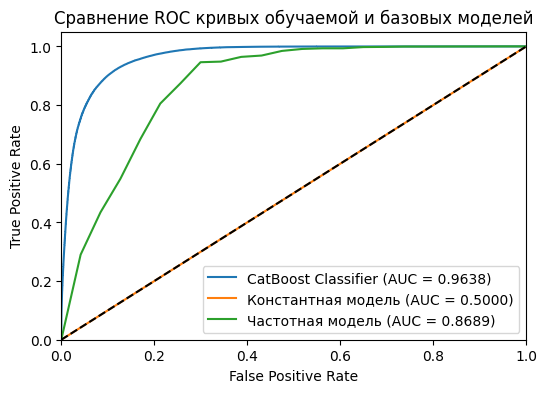

In [16]:
plt.figure(figsize=(6, 4))
y_pred_proba_class_1 = np.array(y_pred_proba)[:, :, 1].T 
plot_roc_curve(y_true, y_pred_proba_class_1, 'CatBoost Classifier')

constant_baseline_proba = np.full(y_true.shape, 0.5)
plot_roc_curve(y_true, constant_baseline_proba, 'Константная модель')

label_frequencies = y_train[target_cols].mean(axis=0)
frequency_based_baseline_proba = np.tile(label_frequencies.values, (y_true.shape[0], 1))
plot_roc_curve(y_true, frequency_based_baseline_proba, 'Частотная модель')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC кривых обучаемой и базовых моделей')
plt.legend(loc='lower right')
plt.show()

##### Сравнение метрик модели с константными предсказаниями

Как видно из графика, частотная baseline модель может показать высокую ROC AUC, если будет выбирать самые популярные продукты.  
Сравним нашу модель с константными более основательно.  
Попробуем в каждом таргете сохранить средние значения по всем наблюдениям.

In [17]:
threshold = 0.02

y_train.mean(axis=0)[y_train.mean(axis=0) > 0.02]

target__ind_1m_checking_acc                 0.0289
target__ind_1m_credit_card                  0.0230
target__ind_1m_salary_acc                   0.0263
target__ind_1m_pension_obligation_account   0.0289
target__ind_1m_debit_account                0.0556
dtype: float64

In [18]:
n_rows = y_pred.shape[0]
n_columns = y_pred.shape[1]


mean_class_probs = y_train.mean(axis=0)
constant_baseline_proba = np.array([
    np.tile([1 - mean_class_probs.iloc[i], mean_class_probs.iloc[i]], (n_rows, 1)) 
    for i in range(n_columns)
])

y_pred_constant = (constant_baseline_proba[:, :, 1].T > threshold).astype(int)

print("Метрики базовой модели на константных средних")
calculate_metrics(y_true, y_pred_constant, constant_baseline_proba)

# Acc = 0, т.к. не было случаев совпадения предсказаний  по всем меткам сразу (т.е. где 5 выбранных таргетов == 1)

Метрики базовой модели на константных средних


,micro,macro,average
Accuracy,-1.0000,-1.0000,0.0000
Precision,0.0190,0.0033,0.0182
Recall,0.4391,0.1739,0.4391
F1,0.0365,0.0064,0.0348
ROC AUC,0.5692,0.5000,0.5000


Видим, что полнота даже выше, чем у нашей модели, то есть константная модель на средних собирает больше 1, но, к сожалению, очень неточно, из-за чего точность < 2%.  Тут даже Accuracy == 0, то есть константы не различают классы.  
  
Другая модель пытается сохранить частоту появления положительных предсказаний для каждого таргета.

In [19]:
y_pred_frequency_based = np.zeros_like(y_true)

for i in range(n_columns):
    num_ones = int(y_train.iloc[:, i].mean() * n_rows)
    ones_indices = np.random.choice(n_rows, num_ones, replace=False)
    y_pred_frequency_based[ones_indices, i] = 1

class_1_frequencies = y_train.mean(axis=0)
y_pred_proba_frequency_based = np.array([
    np.tile([1 - class_1_frequencies.iloc[i], class_1_frequencies.iloc[i]], (n_rows, 1))
    for i in range(n_columns)
])

print("Метрики частотной базовой модели")
metrics = calculate_metrics(y_true, y_pred_frequency_based, y_pred_proba_frequency_based)
metrics

Метрики частотной базовой модели


,micro,macro,average
Accuracy,-1.0000,-1.0000,0.7457
Precision,0.0165,0.0123,0.0454
Recall,0.0139,0.0051,0.0139
F1,0.0151,0.0036,0.0164
ROC AUC,0.5692,0.5000,0.5000


Значение Accuracy высокое, т.к. частоты 0 тоже похожи на реальные, но остальные метрики также на уровне погрешности.  
Таким образом, наша обученная модель не просто знает частоту и средние значения таргетов, а хорошо умеет отделять класс 1 от класса 0 и отличать таргеты друг от друга.

In [20]:
run_id = run.info.run_id
run_details = mlflow.get_run(run_id)

params = run_details.data.params
print("Залогированы параметры:", params)
print("Залогированы метрики:", run_details.data.metrics)

registered_models = mlflow.search_registered_models()

model_found = any(model.name == REGISTRY_MODEL_NAME for model in registered_models)
if model_found:
    print(f"Модель {REGISTRY_MODEL_NAME} была зарегистрирована.")
else:
    print(f"Модель {REGISTRY_MODEL_NAME} НЕ была зарегистрирована.")


Залогированы параметры: {'memory': 'None', 'steps': "[('preprocessor', DataFrameProcessor()), ('encoder', ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',\n                  transformers=[('num', MinMaxScaler(),\n                                 ['age', 'tenure_months', 'income',\n                                  'fetch_year', 'fetch_month',\n                                  'number_of_products']),\n                                ('onehot', OneHotEncoder(drop='first'),\n                                 ['gender', 'client_type_1m',\n                                  'client_activity_1m', 'ind_foreigner',\n                                  'client_segment']),\n                                ('freq',\n                                 FunctionTransformer(func=<function frequency_encoding at 0x7fba2e3f9900>),\n                                 ['entry_channel', 'province_code'])])), ('model', MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier obje

In [21]:
mlflow.end_run()
print("Запуск эксперимента окончен.")

active_run = mlflow.active_run()
if active_run:
    print(f"Активный запуск: {active_run.info.run_id}")
else:
    print("Активных запусков нет.")

2024/09/20 14:13:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run CBC at: http://127.0.0.1:5000/#/experiments/1/runs/490c9234bc3c43bc94bb4f8285187a6a.
2024/09/20 14:13:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


Запуск эксперимента окончен.
Активных запусков нет.


##### Получение рекомендаций на основе вероятностей предсказаний
Т.к. целью (или одной из целей) проекта является получение рекомендаций, мы можем использовать уже полученные нами предсказания y_pred, функцию функцию маппинга interpret_predictions() и выбранный порог, например, 0.1, для выработки рекомендаций нашему тестовому клиенту.

In [22]:
id = load_row_from_json(path(MODEL_DIR, SAMPLE_JSON))['id'][0]
threshold = 0.01

proba_predictions = model.predict_proba(X_test[X_test.id==id])
interpreted_predictions = interpret_predictions([pos_class[1] for prediction in proba_predictions for pos_class in prediction], is_integer=False)
filtered_dict = {k: v for k, v in interpreted_predictions.items() if v >= threshold}
sorted_dict = dict(sorted(filtered_dict.items(), key=lambda item: -item[1]))

print(f'Рекомендации для клиента {id=}:\n')

for key, value in sorted_dict.items():
    print(f"{key}: {round(value, 2)}")

Рекомендации для клиента id=1251582:

Текущие счета: 0.83
Аккаунт для выплаты зарплаты: 0.76
Кредитная карта: 0.71
Дебетовый аккаунт: 0.4
Аккаунт для пенсионных обязательств: 0.4
Зарплатный проект: 0.08


##### Итоги этапа моделирования
 - поднят сервер MLFlow
 - загружен тренировочный датасет и сохраненная модель
 - подобран объем тренировочных данных (данные за 8 месяцев), тестовых данных (за 2 месяца) и параметры модели (малое количество итераций = 100, веса классов = [1, 4])
 - проведена подготовка к встраиванию модели в сервис предсказаний
 - получены метрики модели и проведена их интерпретация:
   - Precision	0.3167
   - Recall	0.2371
   - F1	0.2712
   - ROC AUC	0.9581
 - проведене сравнение результатов предсказаний модели с константными предсказаниями
 - на протяжении всего этапа производилось логирование артефактов и метрик в текущем запуске эксперимента MLFlow
 - обученная модель залогирована, запуск эксперимента окончен
 - построенная структура позволяет проводить оптимизацию (кросс-валидацию) пайплайна обработки данных и подбора алгорима обучения и гиперпараметров с использованием инструментов sklearn или Optuna